# **Mixed samples spectral analysis - Notebook 1**

Comparitive analysis of single-cell spectra in a mixed population.

**About the analysis:**
- Plotting of emmission spectra from different emmission wavelengths.
- Descriptive statistical plots to assess data quality and distribution.
- PCA analysis to separate populations.

**About the experiment:** \
Images are 77k fluorescence emmission spectra from far-red adapting cyanobacteria _Chroococcidiopsis thermalis_ cryofixed on a cryoEM grid. \
Cell were excited with 400nm, 480nm and 580nm. Note that these are different datasets, and so identical cell counts between experiments are not expected. \
Imaging was performed on a Leica Stellaris 8 cryo system, equipped with HyDS detector and White Light Laser. \
In far-red light growing conditions, chlorophyll a is suplemented by far-red absorbing chlorophyll f, which leads to a red-shift of the chlorophyll peak in emmission spectra. \
Cells grown in visible light and far-red light are mixed together to form a heterogenous population, that can be separated based on spectral properties.

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


#### **Import data**

Read StellarStats csv outputs:

In [4]:
path_440 = "440nm/combined_intensity_data.csv"
path_448 = "480nm/combined_intensity_data.csv"
path_580 = "580nm/combined_intensity_data.csv"

Organise dataframe:

In [10]:
df_440 = pd.read_csv(path_440)
df_448 = pd.read_csv(path_448)
df_580 = pd.read_csv(path_580)

df_440['image_ID'] = df_440['image'].str.split('_MIP_seg.npy__mean_intensity_').str[0]
df_440['cell_ID'] = df_440['image'].str.extract(r'_MIP_seg.npy__mean_intensity_(\d+)$')[0]

df_448['image_ID'] = df_448['image'].str.split('_MIP_seg.npy__mean_intensity_').str[0]
df_448['cell_ID'] = df_448['image'].str.extract(r'_MIP_seg.npy__mean_intensity_(\d+)$')[0]

df_580['image_ID'] = df_580['image'].str.split('_MIP_seg.npy__mean_intensity_').str[0]
df_580['cell_ID'] = df_580['image'].str.extract(r'_MIP_seg.npy__mean_intensity_(\d+)$')[0]



datasets = [
    ("440 nm", df_440),
    ("448 nm", df_448),
    ("580 nm", df_580)
]

#### **Exploratory plots**

Plot raw single cell spectra:

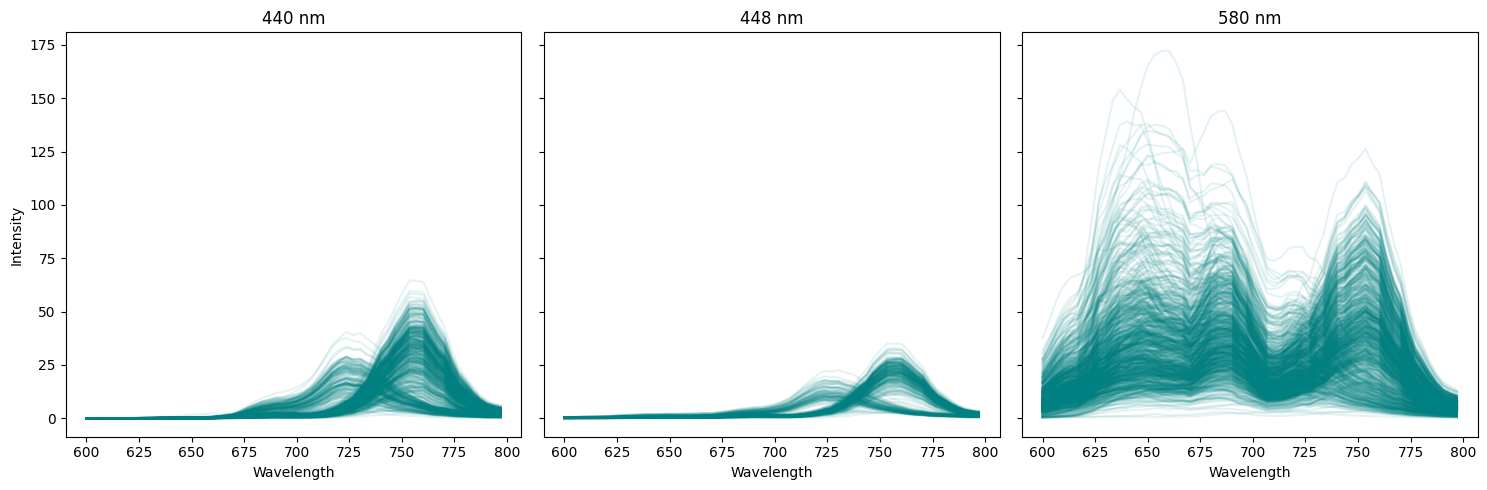

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (label, df) in zip(axes, datasets):
    for image, group_data in df.groupby('image'):
        ax.plot(group_data['wavelength'], group_data['intensity'], alpha=0.1, color='teal')
    ax.set_title(label)
    ax.set_xlabel("Wavelength")
    if ax == axes[0]:  # Only first subplot gets y-axis label
        ax.set_ylabel("Intensity")

plt.tight_layout()
plt.show()

Plot histogram of maximum intensity for each cell. If necessary, add minimal intensity cut-off to remove false segmentations or out-of-focus cells from analysis.

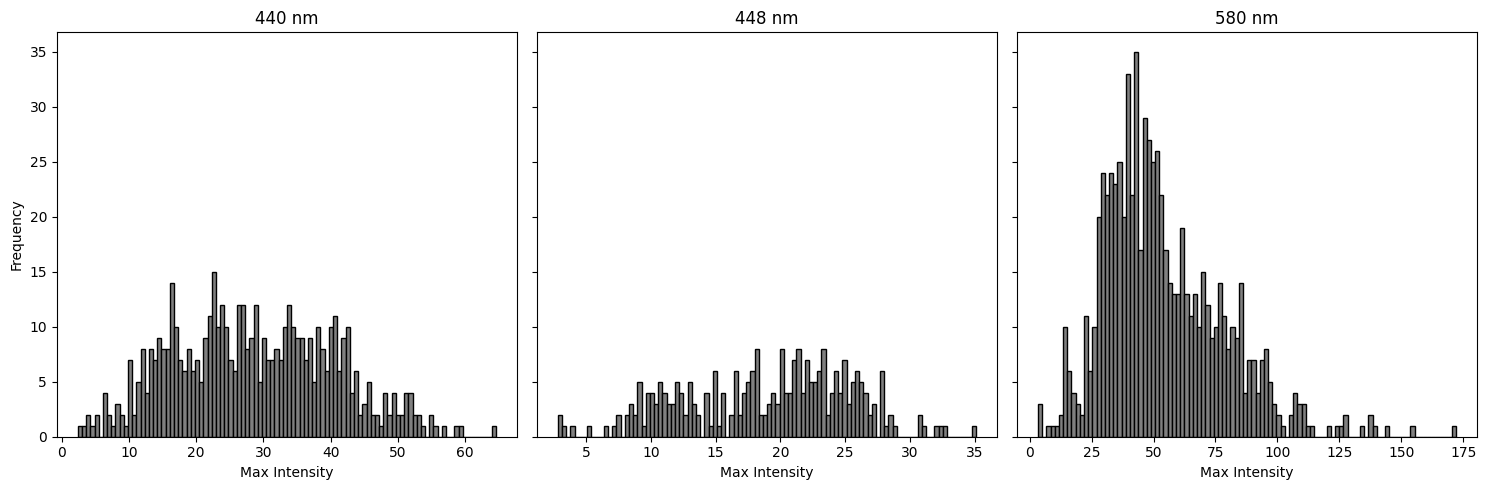

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (label, df) in zip(axes, datasets):
    max_intensity_per_image = df.groupby('image')['intensity'].max().reset_index()
    ax.hist(max_intensity_per_image['intensity'], bins=100, color='gray', edgecolor='black')
    ax.set_title(f"{label}")
    ax.set_xlabel("Max Intensity")
    if ax == axes[0]:
        ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


Plot distribution of brightest wavelengths. This can give an initial indication of subpopulations within the data, or can be use to exclude non-physiological results from analysis.

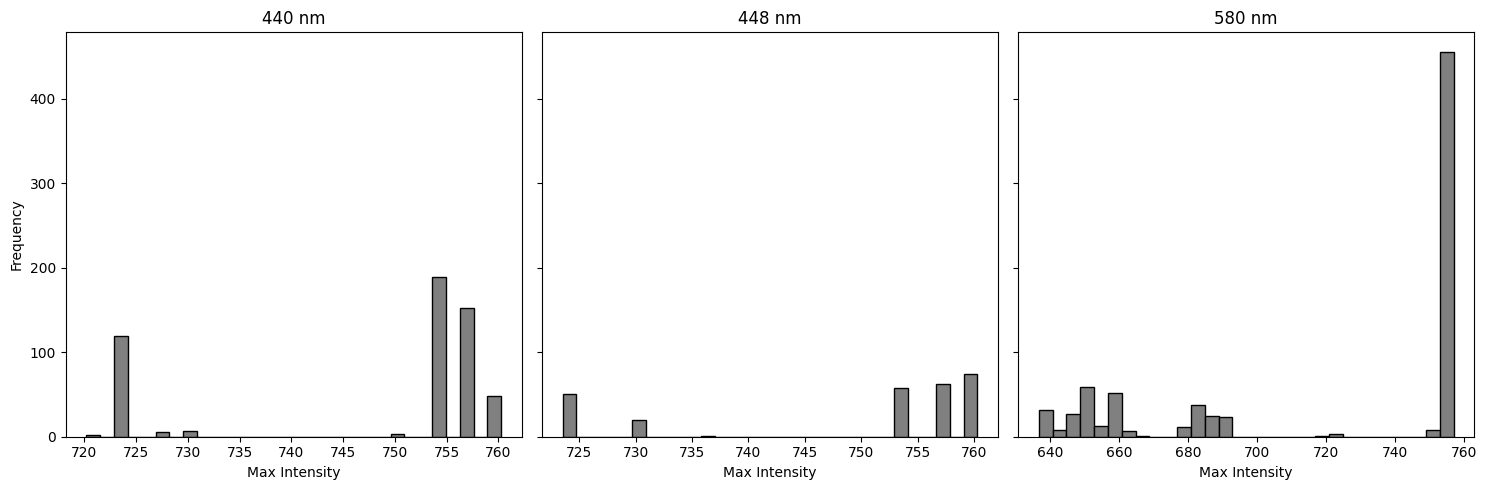

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (label, df) in zip(axes, datasets):
    max_intensity_wavelength = df.loc[df.groupby('image')['intensity'].idxmax(), ['image', 'wavelength', 'intensity']]
    ax.hist(max_intensity_wavelength['wavelength'], bins=30, color='gray', edgecolor='black')
    ax.set_title(f"{label}")
    ax.set_xlabel("Max Intensity")
    if ax == axes[0]:
        ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


#### **Normalise data**

Our tests suggest that spectra cannot be directly compared by their raw intensity values, since many acquisition and optical perturbations can affect signal intensity. To make comparitive statements about cell spectra, it is therefore best to normalise spectra. Here, we normalise to chlorophyll signal, which is found between 710 and 780, depending on growth conditions. We normalise to the maximum peak across this range.

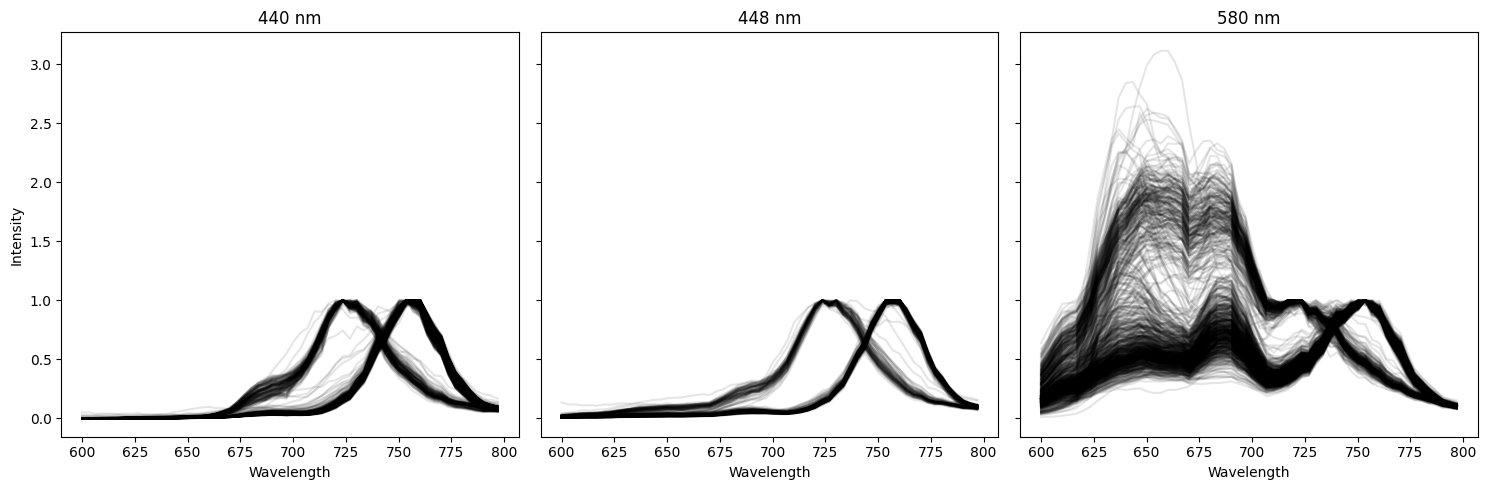

In [77]:
normalized_datasets = []

for label, df in datasets:
    df_norm = df.copy()
    
    for image, group_data in df_norm.groupby('image'):
        range_mask = (group_data['wavelength'] >= 710) & (group_data['wavelength'] <= 780)
        values_in_range = group_data['intensity'][range_mask]

        if not values_in_range.empty:
            max_in_range = values_in_range.max()
            df_norm.loc[group_data.index, 'intensity'] = group_data['intensity'] / max_in_range

    max_norm = df_norm.groupby('image')['intensity'].max()
    droplist = max_norm[max_norm < 0].index.tolist()
    df_norm = df_norm[~df_norm['image'].isin(droplist)]
    
    normalized_datasets.append((label, df_norm))


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (label, df) in zip(axes, normalized_datasets):
    for image, group_data in df.groupby('image'):
        ax.plot(group_data['wavelength'], group_data['intensity'], alpha=0.1, color='black')
    ax.set_title(label)
    ax.set_xlabel("Wavelength")
    if ax == axes[0]:  # Only first subplot gets y-axis label
        ax.set_ylabel("Intensity")

plt.tight_layout()
plt.show()

Plot mean spectra after normalisation, with standard deviation.

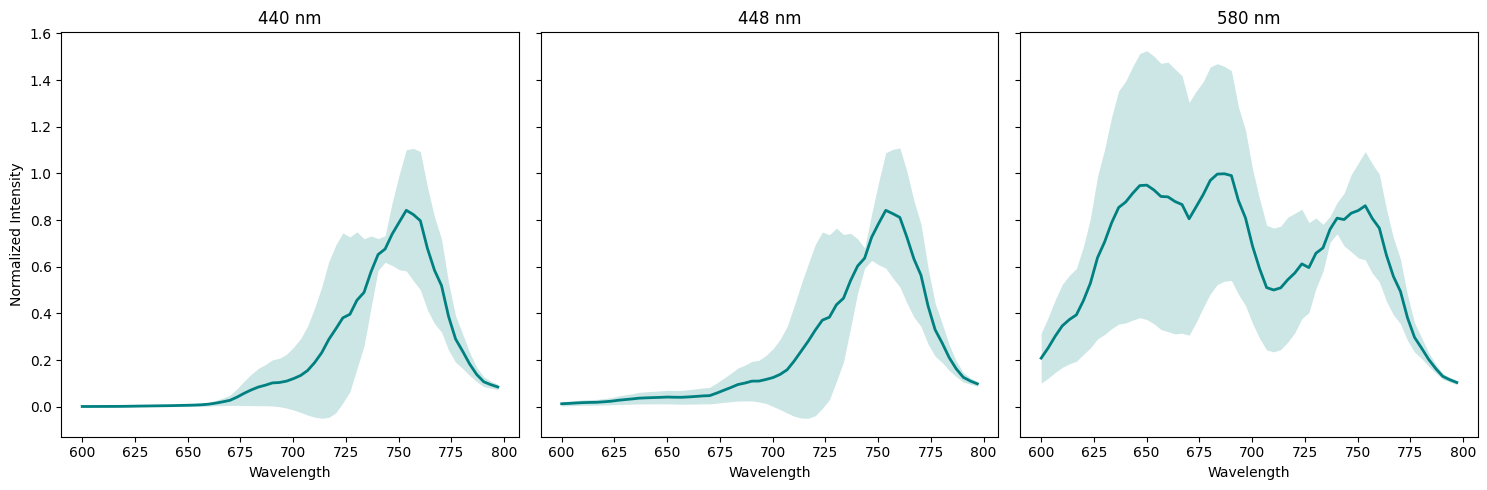

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (label, df_norm) in zip(axes, normalized_datasets):
    mean = df_norm.groupby('wavelength')['intensity'].mean()
    stdev = df_norm.groupby('wavelength')['intensity'].std()

    ax.plot(mean.index, mean, label='Mean Intensity', color='teal', linewidth=2)
    ax.fill_between(mean.index, mean - stdev, mean + stdev, alpha=0.2, color='teal', linewidth=0)

    ax.set_title(label)
    ax.set_xlabel("Wavelength")
    if ax == axes[0]:
        ax.set_ylabel("Normalized Intensity")

plt.tight_layout()
plt.show()


#### **Classification**

Within the bulk set of cells, we have significant variation. This is apparent in the comparison between single cell spectra and mean spectra. To separate subpopulations withiin the data in an unbiased manner, we can perform K-means based clustering. Clusters are visualised by a simple PCA, and mean spectra from each cluster and cluster occupation are reported.

Value `k` is a tunable parameter that dictates the number of clusters to look for. This is an a-priori variable, but can heavily affect results.

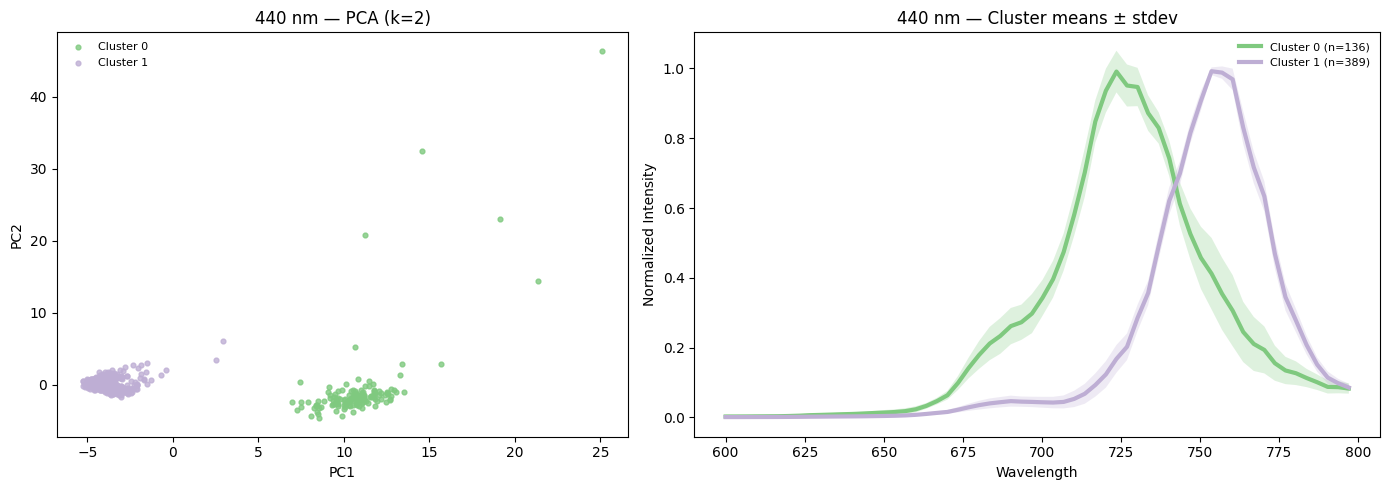

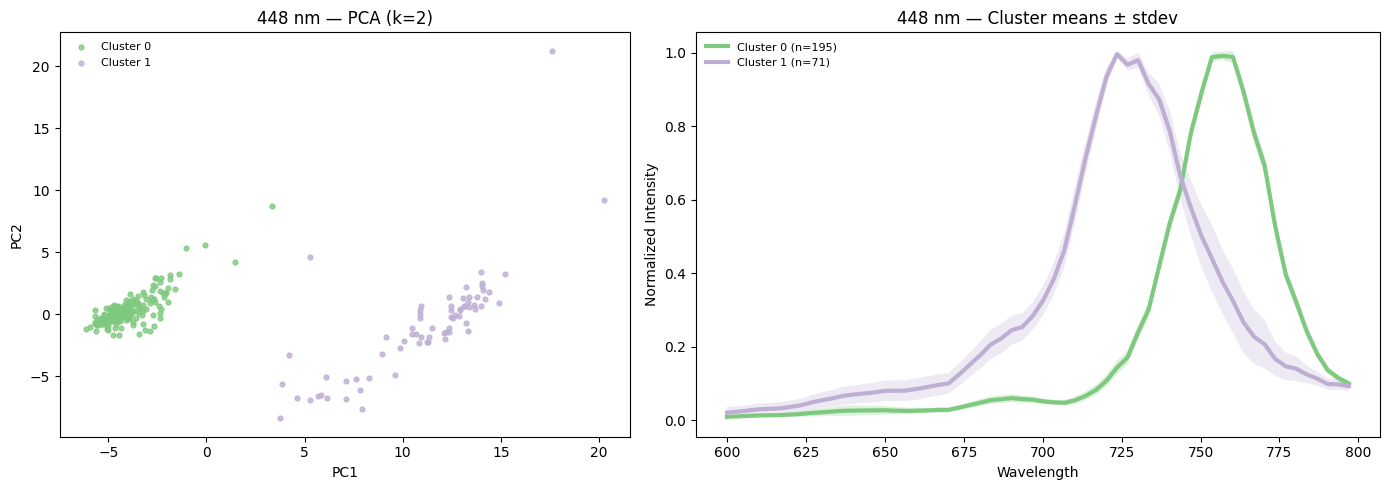

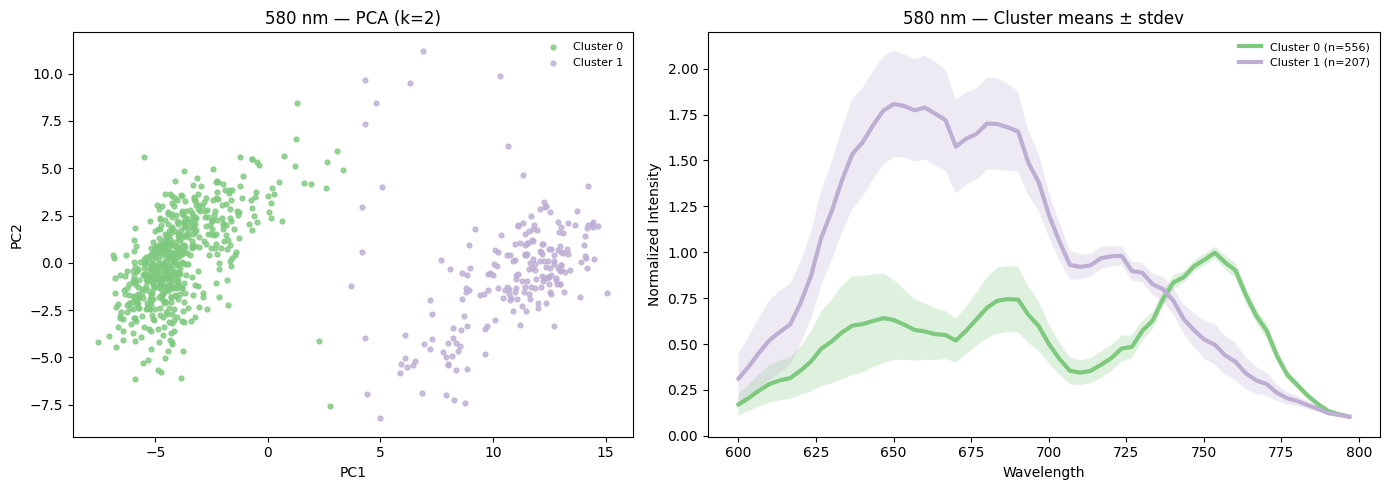

In [79]:
k = 2  # choose your number of classes

for label, df_norm in normalized_datasets:
    df_wide = df_norm.pivot(index='image', columns='wavelength', values='intensity').fillna(0)
    wavelengths = np.array(sorted(df_wide.columns))
    X = df_wide[wavelengths].to_numpy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(X_scaled)

    pca = PCA(n_components=2, random_state=0)
    X_pca = pca.fit_transform(X_scaled)

    cmap = plt.get_cmap('Accent')
    colors = [cmap(i % 10) for i in range(k)]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1.2]})

    ax = axes[0]
    for cid in range(k):
        mask = clusters == cid
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], s=12, alpha=0.8, label=f"Cluster {cid}", color=colors[cid])
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"{label} — PCA (k={k})")
    ax.legend(loc='best', fontsize=8, frameon=False)

    ax = axes[1]
    for cid in range(k):
        mask = clusters == cid
        spectra = X[mask, :]
        if spectra.size == 0:
            continue
        mean_spec = spectra.mean(axis=0)
        std_spec  = spectra.std(axis=0, ddof=1)

        ax.fill_between(
            wavelengths,
            mean_spec - std_spec,
            mean_spec + std_spec,
            alpha=0.25,
            facecolor=colors[cid],
            edgecolor=None,
            linewidth=0
        )
        
        ax.plot(wavelengths, mean_spec, color=colors[cid], linewidth=3, label=f"Cluster {cid} (n={spectra.shape[0]})")

    ax.set_xlabel("Wavelength")
    ax.set_ylabel("Normalized Intensity")
    ax.set_title(f"{label} — Cluster means ± stdev")
    ax.legend(loc='best', fontsize=8, frameon=False)

    plt.tight_layout()
    plt.show()